In [68]:
!pip install pytorchts -q

In [69]:
import requests
url = 'https://raw.githubusercontent.com/vpozdnyakov/probabilistic_forecasting/main/models/metrics.py'
open('metrics.py', 'wb').write(requests.get(url).content);

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.base.transform import BoxCox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.stattools import pacf
from metrics import quantile_loss

import warnings
warnings.filterwarnings('ignore', category=InterpolationWarning)

from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.common import ListDataset

import torch
from pts.model.deepvar import DeepVAREstimator
from pts import Trainer
device = 'cuda'

In [71]:
aus_retail = pd.read_csv('https://raw.githubusercontent.com/vpozdnyakov/probabilistic_forecasting/main/datasets/aus_retail.csv',  index_col=0)
aus_retail.index = pd.to_datetime(aus_retail.index)

In [72]:
train_start = pd.Timestamp('1982-04-01')
train_end = pd.Timestamp('2016-02-01')
test_start = pd.Timestamp('2011-02-01')

In [73]:
train = aus_retail[aus_retail.index <= train_end].iloc[:, :4]
test = aus_retail[aus_retail.index > train_end].iloc[:, :4]
train.shape, test.shape

((407, 4), (60, 4))

### Without scaling

In [74]:
t_train = train.copy()

In [75]:
train_ds = ListDataset(
    [{'target': ts, 'start': train_start} for ts in t_train.values.T],
    freq='M')

test_ds = ListDataset(
    [{'target': ts, 'start': test_start} for ts in t_train.values[-60:].T],
    freq='M')

In [76]:
train_grouper = MultivariateGrouper(
    max_target_dim=4)
test_grouper = MultivariateGrouper(
    max_target_dim=4)

dataset_train = train_grouper(train_ds)
dataset_test = test_grouper(test_ds)

In [77]:
estimator = DeepVAREstimator(
    freq="1M",
    prediction_length=60,
    input_size=17,
    target_dim=4,
    trainer=Trainer(
        device=device,
        epochs=16,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64))

In [78]:
predictor = estimator.train(dataset_train)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)
98it [00:03, 30.30it/s, avg_epoch_loss=27.1, epoch=0]
99it [00:03, 31.50it/s, avg_epoch_loss=22.3, epoch=1]
99it [00:03, 30.99it/s, avg_epoch_loss=24.1, epoch=2]
99it [00:03, 31.78it/s, avg_epoch_loss=24.2, epoch=3]
99it [00:03, 32.14it/s, avg_epoch_loss=25.1, epoch=4]
99it [00:03, 31.74it/s, avg_epoch_loss=23.8, epoch=5]
96it [00:03, 31.22it/s, avg_epoch_loss=21.5, epoch=6]
98it [00:03, 31.27it/s, avg_epoch_loss=20.4, epoch=7]
96it [00:03, 30.59it/s, avg_epoch_loss=19.5, epoch=8]
98it [00:03, 31.42it/s, avg_epoch_loss=19.1, epoch=9]
99it [00:03, 31.60it/s, avg_epoch_loss=18.4, epoch=10]
96it [0

In [79]:
forecasts = list(predictor.predict(dataset_test, num_samples=1000))
forecast = forecasts[0].samples
proba_forecast = np.quantile(forecast, q=[0.025, 0.5, 0.975], axis=0, )
point_forecast = proba_forecast[1]
lower_forecast = proba_forecast[0]
upper_forecast = proba_forecast[2]

/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)


In [80]:
pred = pd.DataFrame(
    point_forecast, columns=test.columns, index=test.index[-60:])
lower = pd.DataFrame(
    lower_forecast, columns=test.columns, index=test.index[-60:])
upper = pd.DataFrame(
    upper_forecast, columns=test.columns, index=test.index[-60:])

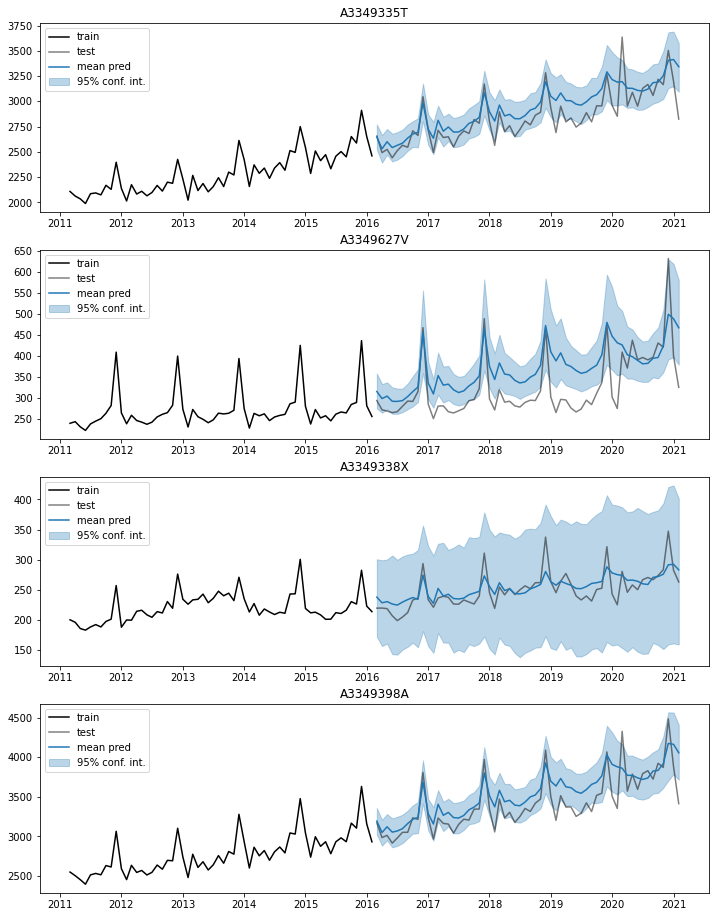

In [81]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-60:], c='black', label='train')
    plt.plot(test[col].iloc[-60:], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(pred.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)

In [82]:
y_pred = np.stack([lower.values, pred.values, upper.values], axis=2)
print('Quantile loss: {:.4f}'.format(quantile_loss(y_pred, test.values)))

Quantile loss: 0.0760


In [83]:
gen_corr = np.corrcoef(forecast.reshape(4, 1000*60))
test_corr = np.corrcoef(test.values.T)

print('Correlation loss: {:.4f}'.format(mse(gen_corr, test_corr)))

Correlation loss: 0.0100


In [84]:
generated_ts = forecast

nlags = 20
nts = generated_ts.shape[2]
ngen = generated_ts.shape[0]
gen_pacfs = np.zeros((ngen, nts, nlags))
for gen_id in range(ngen):
    for ts_id in range(nts):
        gen_pacfs[gen_id, ts_id] = pacf(generated_ts[gen_id, :, ts_id], nlags=nlags)[1:]
gen_pacfs = gen_pacfs.mean(axis=0)

test_pacfs = np.zeros((nts, nlags))
for ts_id in range(nts):
    test_pacfs[ts_id] = pacf(test.values[:, ts_id], nlags=nlags)[1:]

print('PACF loss: {:.4f}'.format(mse(gen_pacfs, test_pacfs)))

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


PACF loss: 0.2890


### Box-Cox transformation

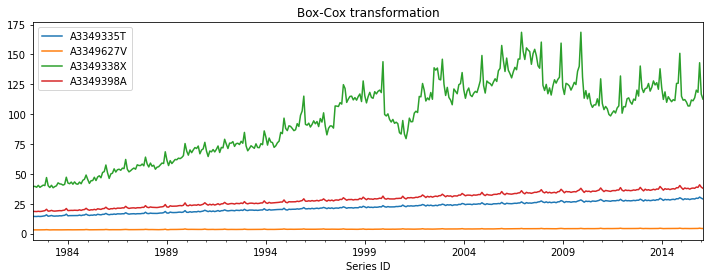

In [85]:
boxcox_model = BoxCox()
lambds = {}
bc_train = train.copy()
for col in train.columns:
    bc_train[col], lambds[col] = boxcox_model.transform_boxcox(
        train[col].values, method='loglik')
bc_train.plot(figsize=(12, 4))
plt.title('Box-Cox transformation')
plt.show()

In [86]:
lambds

{'A3349335T': 0.2849374963384148,
 'A3349338X': 0.85262045917212,
 'A3349398A': 0.3239342116951898,
 'A3349627V': -0.10305050735646222}

In [87]:
train_ds = ListDataset(
    [{'target': ts, 'start': train_start} for ts in bc_train.values.T],
    freq='M')

test_ds = ListDataset(
    [{'target': ts, 'start': test_start} for ts in bc_train.values[-60:].T],
    freq='M')

In [88]:
train_grouper = MultivariateGrouper(
    max_target_dim=4)
test_grouper = MultivariateGrouper(
    max_target_dim=4)

dataset_train = train_grouper(train_ds)
dataset_test = test_grouper(test_ds)

In [89]:
estimator = DeepVAREstimator(
    freq="1M",
    prediction_length=60,
    input_size=17,
    target_dim=4,
    trainer=Trainer(
        device=device,
        epochs=16,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64))

In [90]:
predictor = estimator.train(dataset_train)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)
97it [00:03, 30.03it/s, avg_epoch_loss=15.7, epoch=0]
96it [00:03, 30.39it/s, avg_epoch_loss=9.75, epoch=1]
99it [00:03, 31.82it/s, avg_epoch_loss=14.3, epoch=2]
99it [00:03, 32.20it/s, avg_epoch_loss=14.8, epoch=3]
99it [00:03, 31.76it/s, avg_epoch_loss=14.1, epoch=4]
99it [00:03, 31.62it/s, avg_epoch_loss=12.5, epoch=5]
99it [00:03, 31.27it/s, avg_epoch_loss=12, epoch=6]
97it [00:03, 30.60it/s, avg_epoch_loss=11.3, epoch=7]
99it [00:03, 31.59it/s, avg_epoch_loss=12.8, epoch=8]
99it [00:03, 31.79it/s, avg_epoch_loss=12.3, epoch=9]
99it [00:03, 31.90it/s, avg_epoch_loss=10.3, epoch=10]
99it [00:

In [91]:
forecasts = list(predictor.predict(dataset_test, num_samples=100))
forecast = forecasts[0].samples
proba_forecast = np.quantile(forecast, q=[0.025, 0.5, 0.975], axis=0, )
lower_forecast = proba_forecast[0]
point_forecast = proba_forecast[1]
upper_forecast = proba_forecast[2]

/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)


In [92]:
bc_pred = pd.DataFrame(
    point_forecast, columns=test.columns, index=test.index)
bc_lower = pd.DataFrame(
    lower_forecast, columns=test.columns, index=test.index)
bc_upper = pd.DataFrame(
    upper_forecast, columns=test.columns, index=test.index)

In [93]:
pred = bc_pred.copy()
lower = bc_lower.copy()
upper = bc_upper.copy()
for col in bc_pred.columns:
    pred[col] = inv_boxcox(bc_pred[col].values, lambds[col])
    lower[col] = inv_boxcox(bc_lower[col].values, lambds[col])
    upper[col] = inv_boxcox(bc_upper[col].values, lambds[col])

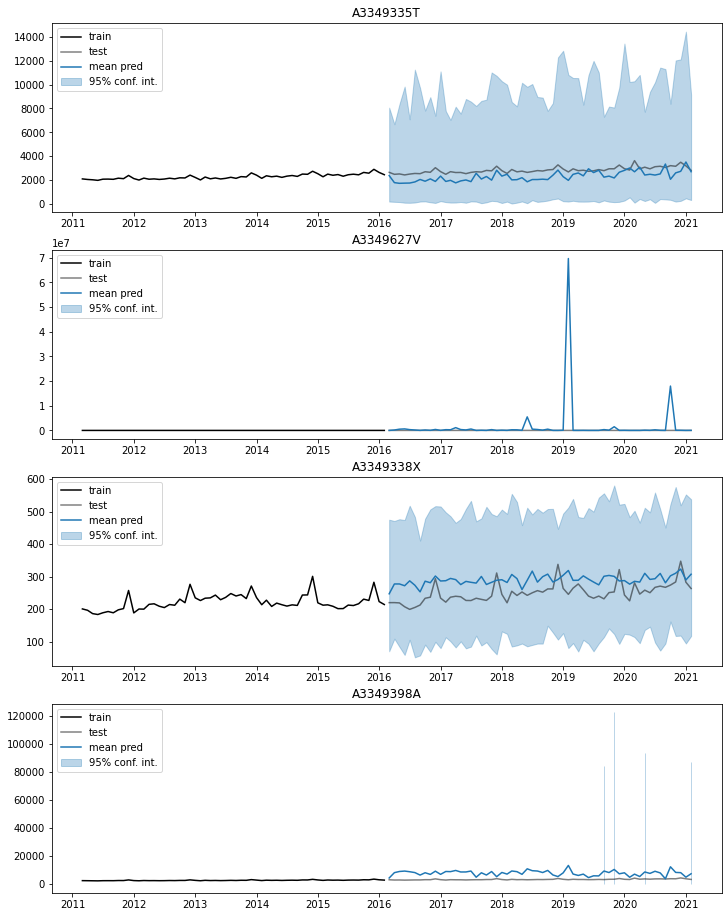

In [94]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-60:], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(pred.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)

### box cox + seasonal differencing

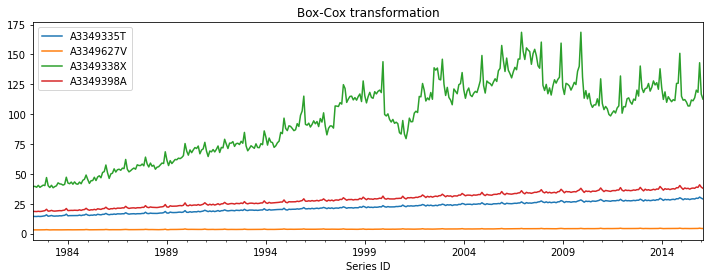

In [95]:
boxcox_model = BoxCox()
lambds = {}
bc_train = train.copy()
for col in train.columns:
    bc_train[col], lambds[col] = boxcox_model.transform_boxcox(
        train[col].values, method='loglik')
bc_train.plot(figsize=(12, 4))
plt.title('Box-Cox transformation')
plt.show()

In [96]:
def differencing(ts, periods):
    return ts.diff(periods=periods).dropna()

def integration(ts, periods, original_ts):
    ts_concat = pd.concat([original_ts.iloc[:periods], ts])
    ts_integration = []
    for i in range(periods):
        ts_integration.append(ts_concat.iloc[i::periods].cumsum(axis=0))
    return pd.concat(ts_integration).sort_index()

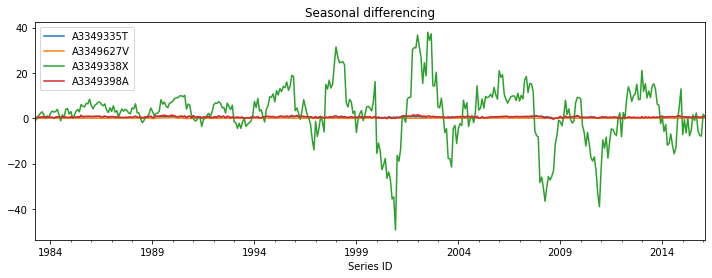

In [97]:
seasonal_lag = 12
t_train = differencing(bc_train, seasonal_lag)
t_train.plot(figsize=(12, 4))
plt.title('Seasonal differencing')
plt.show()

In [98]:
train_ds = ListDataset(
    [{'target': ts, 'start': train_start} for ts in t_train.values.T],
    freq='M')

test_ds = ListDataset(
    [{'target': ts, 'start': test_start} for ts in t_train.values[-60:].T],
    freq='M')

In [99]:
train_grouper = MultivariateGrouper(
    max_target_dim=4)
test_grouper = MultivariateGrouper(
    max_target_dim=4)

dataset_train = train_grouper(train_ds)
dataset_test = test_grouper(test_ds)

In [100]:
estimator = DeepVAREstimator(
    freq="1M",
    prediction_length=60,
    input_size=17,
    target_dim=4,
    trainer=Trainer(
        device=device,
        epochs=16,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64))

In [101]:
predictor = estimator.train(dataset_train)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)
97it [00:03, 30.46it/s, avg_epoch_loss=3.18, epoch=0]
98it [00:03, 30.47it/s, avg_epoch_loss=0.281, epoch=1]
98it [00:03, 30.82it/s, avg_epoch_loss=-.888, epoch=2]
96it [00:03, 30.65it/s, avg_epoch_loss=-1.17, epoch=3]
99it [00:03, 31.96it/s, avg_epoch_loss=-1.97, epoch=4]
99it [00:03, 32.52it/s, avg_epoch_loss=-2.41, epoch=5]
99it [00:03, 31.92it/s, avg_epoch_loss=-3.38, epoch=6]
99it [00:03, 32.14it/s, avg_epoch_loss=-4.18, epoch=7]
98it [00:03, 31.36it/s, avg_epoch_loss=-4.8, epoch=8]
98it [00:03, 31.55it/s, avg_epoch_loss=-5.16, epoch=9]
99it [00:03, 31.96it/s, avg_epoch_loss=-5.59, epoch=10

In [102]:
forecasts = list(predictor.predict(dataset_test, num_samples=1000))
forecast = forecasts[0].samples
proba_forecast = np.quantile(forecast, q=[0.025, 0.5, 0.975], axis=0, )
lower_forecast = proba_forecast[0]
point_forecast = proba_forecast[1]
upper_forecast = proba_forecast[2]

/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)


In [103]:
point_forecast = pd.DataFrame(
    point_forecast, columns=test.columns, index=test.index)
lower_forecast = pd.DataFrame(
    lower_forecast, columns=test.columns, index=test.index)
upper_forecast = pd.DataFrame(
    upper_forecast, columns=test.columns, index=test.index)

In [104]:
pred = point_forecast.copy()
lower = lower_forecast.copy()
upper = upper_forecast.copy()

In [105]:
bc_pred = integration(point_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_lower = integration(lower_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_upper = integration(upper_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_pred.shape

(60, 4)

In [106]:
bc_lower[bc_lower < 0] = 0

In [107]:
pred = bc_pred.copy()
lower = bc_lower.copy()
upper = bc_upper.copy()
for col in bc_pred.columns:
    pred[col] = inv_boxcox(bc_pred[col].values, lambds[col])
    lower[col] = inv_boxcox(bc_lower[col].values, lambds[col])
    upper[col] = inv_boxcox(bc_upper[col].values, lambds[col])
pred.head()

,A3349335T,A3349627V,A3349338X,A3349398A
Series ID,,,,
2016-03-01,2609.795943,285.125726,216.245909,3117.262421
2016-04-01,2515.791430,264.563045,211.658299,2995.453221
2016-05-01,2569.412012,274.326320,207.401778,3060.692733
2016-06-01,2409.158078,260.198452,205.848438,2880.963526
2016-07-01,2546.063512,278.843565,216.984565,3042.773611


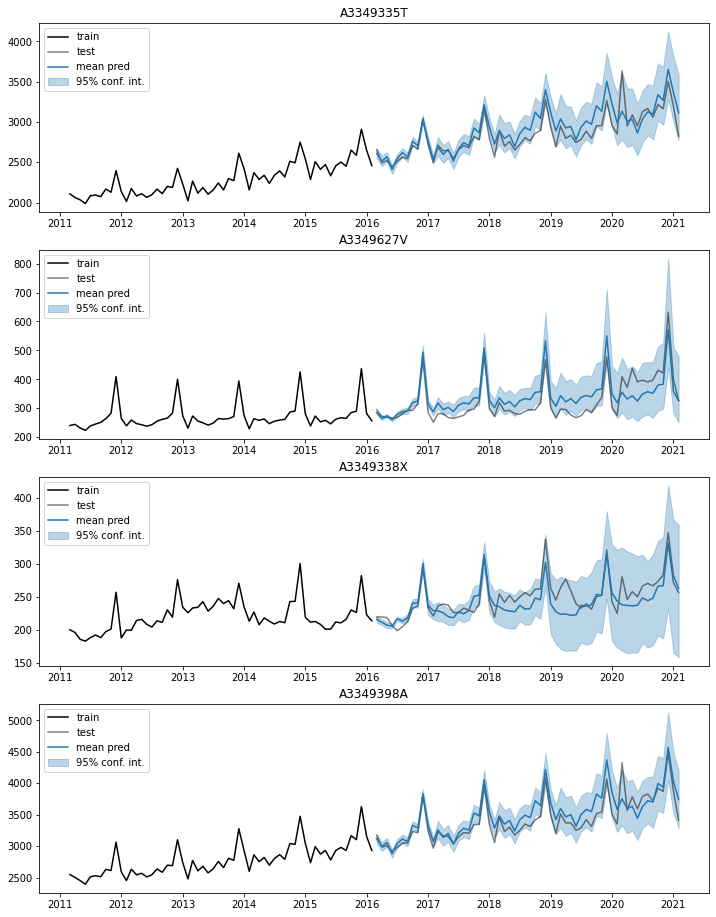

In [108]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-60:], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(pred.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)

### only seasonal

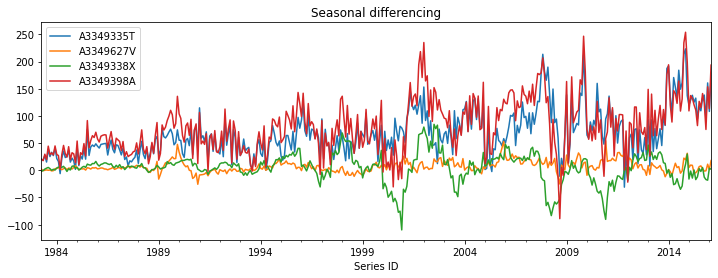

In [109]:
seasonal_lag = 12
t_train = differencing(train, seasonal_lag)
t_train.plot(figsize=(12, 4))
plt.title('Seasonal differencing')
plt.show()

In [110]:
train_ds = ListDataset(
    [{'target': ts, 'start': train_start} for ts in t_train.values.T],
    freq='M')

test_ds = ListDataset(
    [{'target': ts, 'start': test_start} for ts in t_train.values[-60:].T],
    freq='M')

In [111]:
train_grouper = MultivariateGrouper(
    max_target_dim=4)
test_grouper = MultivariateGrouper(
    max_target_dim=4)

dataset_train = train_grouper(train_ds)
dataset_test = test_grouper(test_ds)

In [112]:
estimator = TransformerTempFlowEstimator(
    input_size=14,
    d_model=16,
    num_heads=4,
    target_dim=4,
    prediction_length=60,
    context_length=60,
    flow_type='MAF',
    dequantize=True,
    freq='M',
    trainer=Trainer(
        device=device,
        epochs=10,
        learning_rate=0.1,
        num_batches_per_epoch=1000,
        batch_size=128))

In [113]:
predictor = estimator.train(dataset_train)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)
998it [00:57, 17.29it/s, avg_epoch_loss=-.135, epoch=0]
998it [00:57, 17.31it/s, avg_epoch_loss=-4.07, epoch=1]
998it [00:57, 17.25it/s, avg_epoch_loss=-5.76, epoch=2]
998it [00:57, 17.34it/s, avg_epoch_loss=-6.92, epoch=3]
998it [00:57, 17.30it/s, avg_epoch_loss=-7.84, epoch=4]
998it [00:57, 17.25it/s, avg_epoch_loss=-8.62, epoch=5]
998it [00:57, 17.26it/s, avg_epoch_loss=-9.32, epoch=6]
998it [00:57, 17.32it/s, avg_epoch_loss=-9.92, epoch=7]
998it [00:57, 17.26it/s, avg_epoch_loss=-10.5, epoch=8]
998it [00:57, 17.27it/s, avg_epoch_loss=-10.9, epoch=9]


In [114]:
forecasts = list(predictor.predict(dataset_test, num_samples=100))
forecast = forecasts[0].samples
proba_forecast = np.quantile(forecast, q=[0.025, 0.5, 0.975], axis=0, )
lower_forecast = proba_forecast[0]
point_forecast = proba_forecast[1]
upper_forecast = proba_forecast[2]

/usr/local/lib/python3.7/dist-packages/pts/feature/fourier_date_feature.py:45: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)


In [115]:
point_forecast = pd.DataFrame(
    point_forecast, columns=test.columns, index=test.index)
lower_forecast = pd.DataFrame(
    lower_forecast, columns=test.columns, index=test.index)
upper_forecast = pd.DataFrame(
    upper_forecast, columns=test.columns, index=test.index)

In [116]:
pred = integration(point_forecast, seasonal_lag, train.iloc[-seasonal_lag:]).iloc[-60:]
lower = integration(lower_forecast, seasonal_lag, train.iloc[-seasonal_lag:]).iloc[-60:]
upper = integration(upper_forecast, seasonal_lag, train.iloc[-seasonal_lag:]).iloc[-60:]
pred.shape

(60, 4)

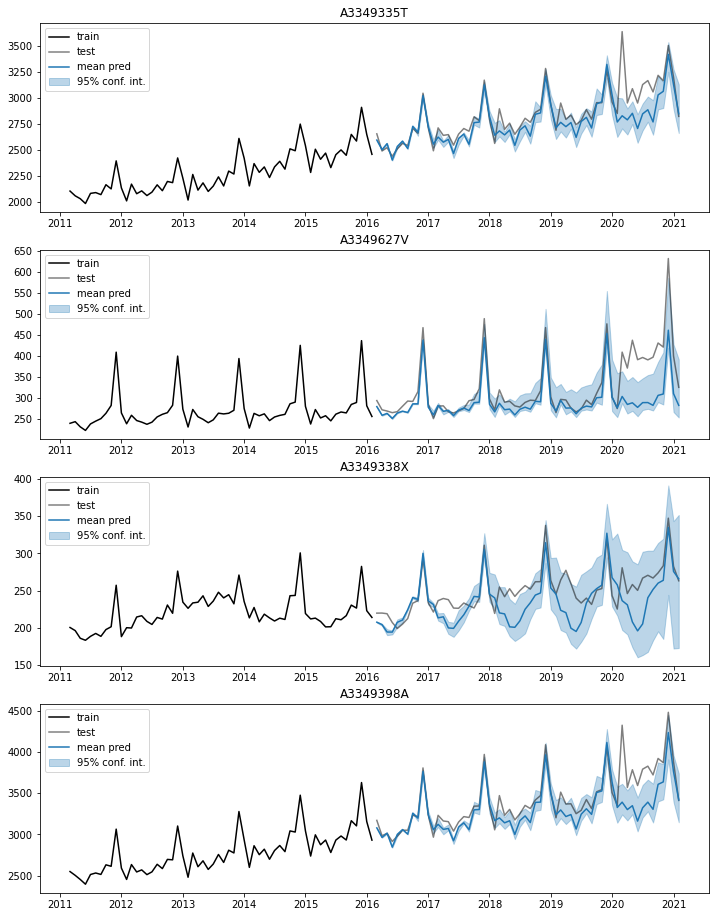

In [117]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-60:], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(pred.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)

In [118]:
y_pred = np.stack([lower.values, pred.values, upper.values], axis=2)
print('Quantile loss: {:.4f}'.format(quantile_loss(y_pred, test.values)))

Quantile loss: 0.0737


In [119]:
gen_corr = np.corrcoef(forecast.reshape(4, 100*60))
test_corr = np.corrcoef(test.values.T)

print('Correlation loss: {:.4f}'.format(mse(gen_corr, test_corr)))

Correlation loss: 0.0021


In [120]:
generated_ts = forecast

nlags = 20
nts = generated_ts.shape[2]
ngen = generated_ts.shape[0]
gen_pacfs = np.zeros((ngen, nts, nlags))
for gen_id in range(ngen):
    for ts_id in range(nts):
        gen_pacfs[gen_id, ts_id] = pacf(generated_ts[gen_id, :, ts_id], nlags=nlags)[1:]
gen_pacfs = gen_pacfs.mean(axis=0)

test_pacfs = np.zeros((nts, nlags))
for ts_id in range(nts):
    test_pacfs[ts_id] = pacf(test.values[:, ts_id], nlags=nlags)[1:]

print('PACF loss: {:.4f}'.format(mse(gen_pacfs, test_pacfs)))

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


PACF loss: 0.0738
